In [231]:
import numpy as np
import string
from collections import OrderedDict
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from nltk.corpus import stopwords 
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\JeannotMunganga\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Some Helper Functions for data preprocessing

In [233]:
def read_one_paragraph(file_path):
    file_content = []
    with open(file_path, encoding='utf8') as file:
        file_content = file.read()
    
    return file_content.split('\n')[0]

def split_and_clean(some_text):
    stop_words = set(stopwords.words("english"))
    cleaned_txt = str(some_text).lower().translate(str.maketrans('','',string.punctuation))
    return [w for w in cleaned_txt.split() if w not in stop_words]

def get_unique_words_in_order(some_list_of_text):
    return list(OrderedDict.fromkeys(some_list_of_text))

def get_one_hot_encodings(vocabulary):
    encodings = []
    word_index_lookup = dict()
    for index, word in enumerate(vocabulary):
        encoding = np.zeros(len(vocabulary))
        encoding[index] = 1
        encodings.append(encoding)
        word_index_lookup.update({word: index})
    return encodings, word_index_lookup

def generate_training_data(cleaned_text, encodings, word_index_lookup, context_size=5):
    X_train = []
    Y_train = []
    
    for index, word in enumerate(cleaned_text):
        word_vocabulary_index = word_index_lookup.get(word)
        word_encoding = encodings[word_vocabulary_index]
        for i in range(index - context_size, index + context_size + 1):
            if i < 0 or i > len(cleaned_text) - 1 or i == index:
                continue
            context_word_vocabulary_index = word_index_lookup.get(cleaned_text[i])
            context_word_encoding = encodings[context_word_vocabulary_index]
            X_train.append(word_encoding)
            Y_train.append(context_word_encoding)
    return np.array(X_train), np.array(Y_train)
            
        

In [234]:
text = read_one_paragraph('assets/harry_potter/HP5.txt')
print(text)

DUDLEY DEMENTED The hottest day of the summer so far was drawing to a close and a drowsy silence lay over the large, square houses of Privet Drive. Cars that were usually gleaming stood dusty in their drives and lawns that were once emerald green lay parched and yellowing; the use of hosepipes had been banned due to drought. Deprived of their usual car-washing and lawn-mowing pursuits, the inhabitants of Privet Drive had retreated into the shade of their cool houses, windows thrown wide in the hope of tempting in a nonexistent breeze. The only person left outdoors was a teenage boy who was lying flat on his back in a flower bed outside number four. He was a skinny, black-haired, bespectacled boy who had the pinched, slightly unhealthy look of someone who has grown a lot in a short space of time. His jeans were torn and dirty, his T-shirt baggy and faded, and the soles of his trainers were peeling away from the uppers. Harry Potter’s appearance did not endear him to the neighbors, who w

In [235]:
cleaned_text = split_and_clean(text)
print(cleaned_text)

['dudley', 'demented', 'hottest', 'day', 'summer', 'far', 'drawing', 'close', 'drowsy', 'silence', 'lay', 'large', 'square', 'houses', 'privet', 'drive', 'cars', 'usually', 'gleaming', 'stood', 'dusty', 'drives', 'lawns', 'emerald', 'green', 'lay', 'parched', 'yellowing', 'use', 'hosepipes', 'banned', 'due', 'drought', 'deprived', 'usual', 'carwashing', 'lawnmowing', 'pursuits', 'inhabitants', 'privet', 'drive', 'retreated', 'shade', 'cool', 'houses', 'windows', 'thrown', 'wide', 'hope', 'tempting', 'nonexistent', 'breeze', 'person', 'left', 'outdoors', 'teenage', 'boy', 'lying', 'flat', 'back', 'flower', 'bed', 'outside', 'number', 'four', 'skinny', 'blackhaired', 'bespectacled', 'boy', 'pinched', 'slightly', 'unhealthy', 'look', 'someone', 'grown', 'lot', 'short', 'space', 'time', 'jeans', 'torn', 'dirty', 'tshirt', 'baggy', 'faded', 'soles', 'trainers', 'peeling', 'away', 'uppers', 'harry', 'potter’s', 'appearance', 'endear', 'neighbors', 'sort', 'people', 'thought', 'scruffiness', 

In [236]:
vocabulary = get_unique_words_in_order(cleaned_text)
print(vocabulary)

['dudley', 'demented', 'hottest', 'day', 'summer', 'far', 'drawing', 'close', 'drowsy', 'silence', 'lay', 'large', 'square', 'houses', 'privet', 'drive', 'cars', 'usually', 'gleaming', 'stood', 'dusty', 'drives', 'lawns', 'emerald', 'green', 'parched', 'yellowing', 'use', 'hosepipes', 'banned', 'due', 'drought', 'deprived', 'usual', 'carwashing', 'lawnmowing', 'pursuits', 'inhabitants', 'retreated', 'shade', 'cool', 'windows', 'thrown', 'wide', 'hope', 'tempting', 'nonexistent', 'breeze', 'person', 'left', 'outdoors', 'teenage', 'boy', 'lying', 'flat', 'back', 'flower', 'bed', 'outside', 'number', 'four', 'skinny', 'blackhaired', 'bespectacled', 'pinched', 'slightly', 'unhealthy', 'look', 'someone', 'grown', 'lot', 'short', 'space', 'time', 'jeans', 'torn', 'dirty', 'tshirt', 'baggy', 'faded', 'soles', 'trainers', 'peeling', 'away', 'uppers', 'harry', 'potter’s', 'appearance', 'endear', 'neighbors', 'sort', 'people', 'thought', 'scruffiness', 'ought']


In [237]:
encodings, word_index_lookup = get_one_hot_encodings(vocabulary)
print(encodings)

[array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
 

In [257]:
X_train, Y_train = generate_training_data(cleaned_text, encodings, word_index_lookup)

In [258]:
X_train.shape

(970, 95)

In [259]:
len(vocabulary)

95

# Neural Network Model

In [260]:
class Model(nn.Module):
    def __init__(self, vocabulary_size, embedding_size):
        super(Model, self).__init__()
        self.hidden_layer = nn.Linear(vocabulary_size, embedding_size)
        self.output_layer = nn.Linear(embedding_size, vocabulary_size)
        
        self._initialize_weights()
        
    def _initialize_weights(self):
        nn.init.normal_(self.hidden_layer.weight, mean=0, std=0.1)
        nn.init.normal_(self.output_layer.weight, mean=0, std=0.1)
        
    def forward(self, target_word):
        h = self.hidden_layer(target_word)
        o = self.output_layer(h)
        y = F.softmax(o, dim=0) 
        return y

# Neural Network Training

In [262]:
model = Model(len(vocabulary), 10)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

X_train_tensor = torch.tensor(X_train, dtype=torch.float)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.float)

num_epochs = 1000

for epoch in range(num_epochs):
    total_loss = 0
    for i in range(X_train_tensor.shape[0]):
        target_word = X_train_tensor[i]
        context_word = Y_train_tensor[i]
        
        output = model(target_word)
        
        loss = loss_function(output, context_word)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(X_train_tensor):.8f}')

Epoch 10/1000, Loss: 4.55373305
Epoch 20/1000, Loss: 4.55358151
Epoch 30/1000, Loss: 4.55333889
Epoch 40/1000, Loss: 4.55272122
Epoch 50/1000, Loss: 4.54715968
Epoch 60/1000, Loss: 4.54209899
Epoch 70/1000, Loss: 4.52564399
Epoch 80/1000, Loss: 4.51604285
Epoch 90/1000, Loss: 4.51370499
Epoch 100/1000, Loss: 4.51194421
Epoch 110/1000, Loss: 4.50937663
Epoch 120/1000, Loss: 4.50756788
Epoch 130/1000, Loss: 4.50581130
Epoch 140/1000, Loss: 4.50470672
Epoch 150/1000, Loss: 4.50401192
Epoch 160/1000, Loss: 4.50345751
Epoch 170/1000, Loss: 4.50280346
Epoch 180/1000, Loss: 4.50131204
Epoch 190/1000, Loss: 4.49869827
Epoch 200/1000, Loss: 4.49718888
Epoch 210/1000, Loss: 4.49453222
Epoch 220/1000, Loss: 4.49041322
Epoch 230/1000, Loss: 4.48916461
Epoch 240/1000, Loss: 4.48863639
Epoch 250/1000, Loss: 4.48822027
Epoch 260/1000, Loss: 4.48783736
Epoch 270/1000, Loss: 4.48747746
Epoch 280/1000, Loss: 4.48715740
Epoch 290/1000, Loss: 4.48689099
Epoch 300/1000, Loss: 4.48667308
Epoch 310/1000, Los

# Given a word can we predict its top context words

In [263]:
def predict(word,number_of_predictions):
    if word in vocabulary:
        index = word_index_lookup.get(word)
        X = encodings[index]
        X_tensor = torch.tensor(X, dtype=torch.float)
        prediction = model.forward(X_tensor)
        output = {}
        for i in range(len(vocabulary)):
            output[vocabulary[i]] = prediction[i].item()
        sorted_items = sorted(output.items(), key=lambda x: x[1], reverse=True)
        output = dict(sorted_items)
        top_context_words = []
        for k in output:
            top_context_words.append(k)
            if len(top_context_words)>=number_of_predictions:
                break

        return top_context_words
    else:
        print("Word not found in dictionary")
predictions = predict('summer', 2)
print(f'Predicted context words: {predictions}')

Predicted context words: ['far', 'teenage']


In [264]:
predictions = predict('torn', 2)
print(f'Predicted context words: {predictions}')

Predicted context words: ['jeans', 'neighbors']


# Plotting all embeddings in 2D, we can see how words are grouped together

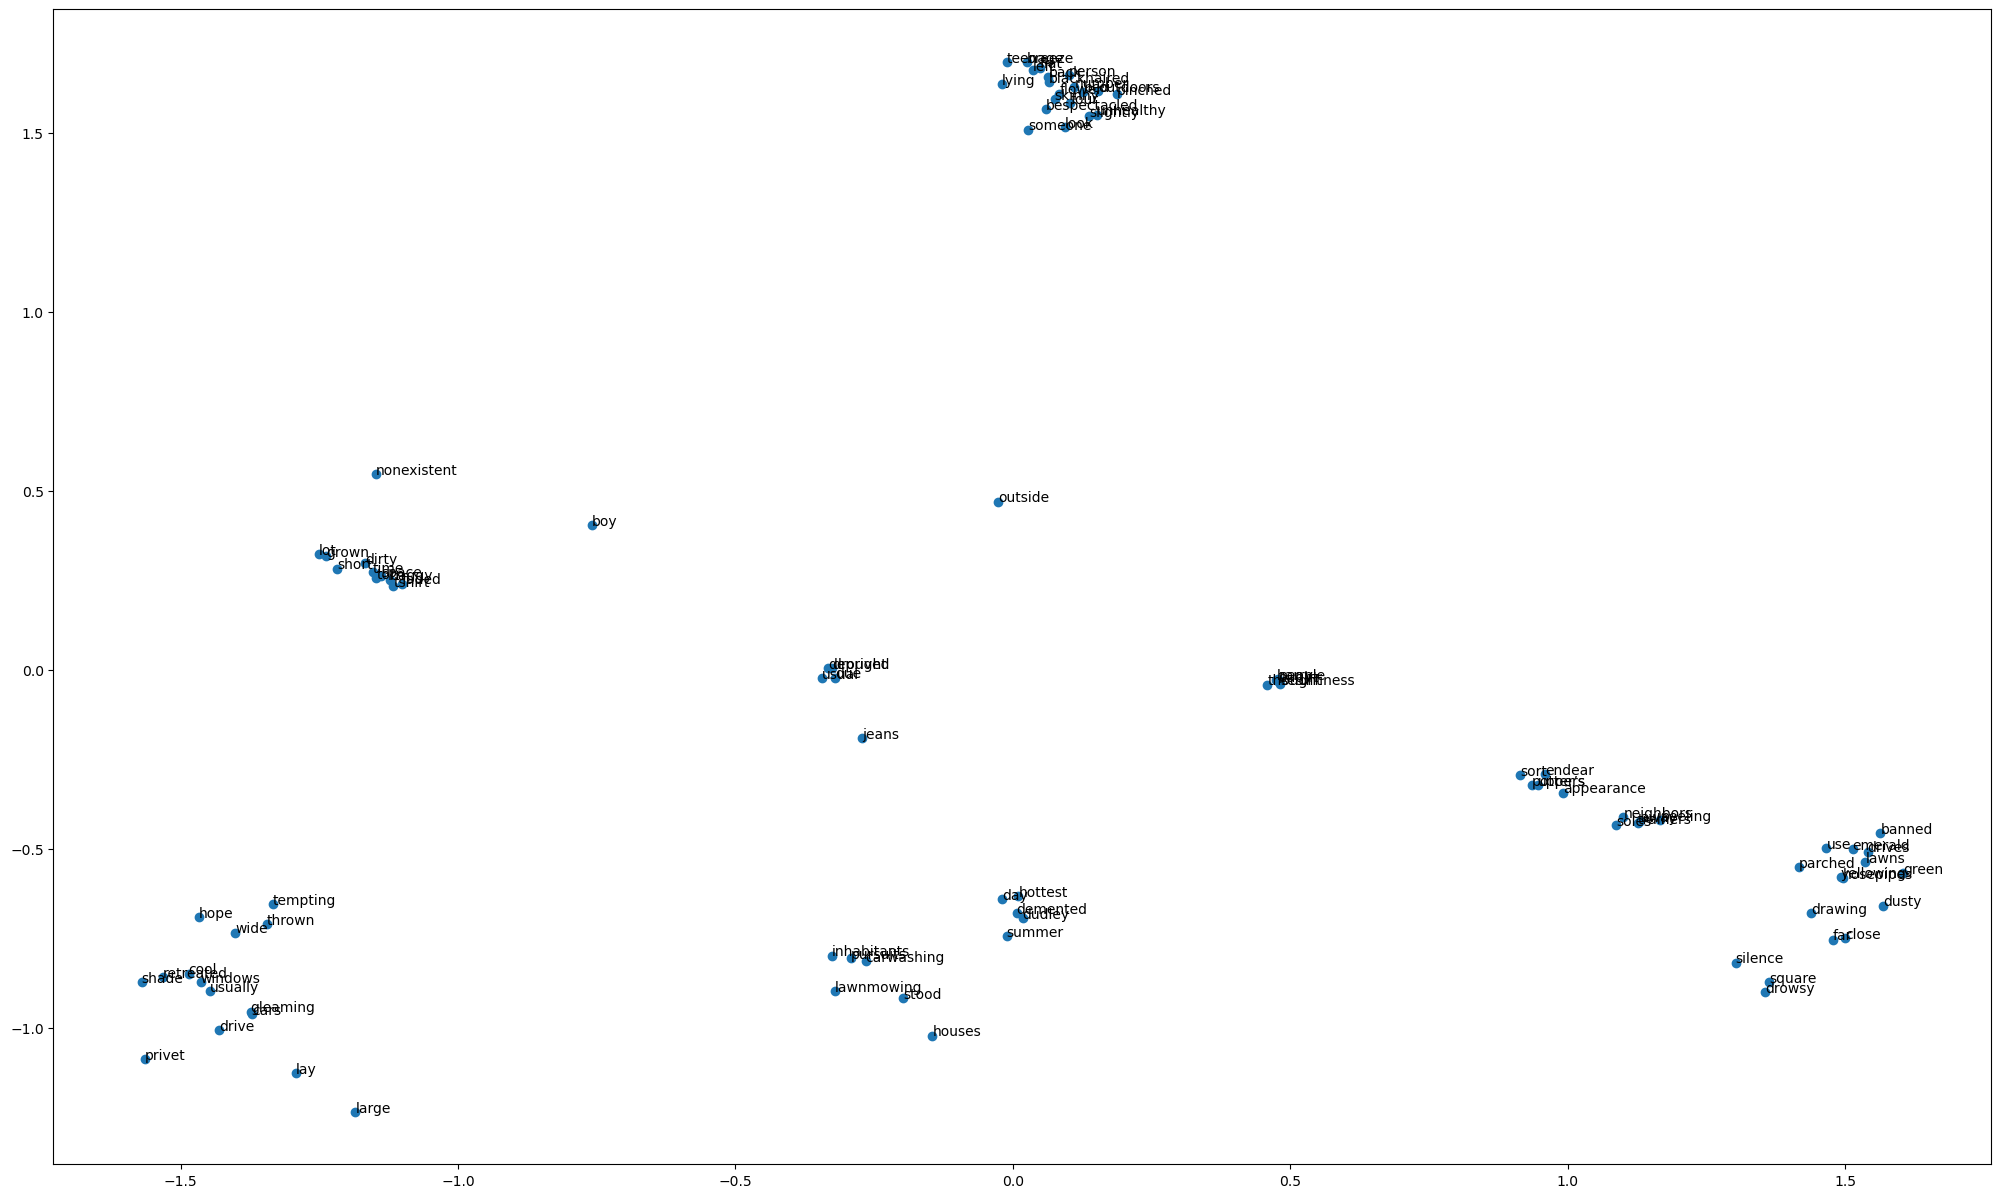

In [265]:
embeddings = []
for index, word in enumerate(vocabulary):
    index = word_index_lookup.get(word)
    X = encodings[index]
    X_tensor = torch.tensor(X, dtype=torch.float)
    embeddings.append(model.hidden_layer(X_tensor).detach().numpy())
    
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)
plt.figure(figsize=(25, 15))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1])
for i, label in enumerate(vocabulary):
        plt.annotate(label, (reduced_embeddings[i, 0], reduced_embeddings[i, 1]))
plt.show()

# Finding the most similar word to a certain given word 

In [267]:
def get_most_similar_word(target_embedding):
    similarities = []
    for embedding in embeddings:
        similarity = F.cosine_similarity(target_embedding.unsqueeze(0), torch.tensor(embedding).unsqueeze(0))
        similarities.append(similarity.item())
    
    max_similarity = sorted(similarities, reverse=True)[1]
    most_similar_index = similarities.index(max_similarity)
    
    # Result
    most_similar_embedding = embeddings[most_similar_index]
    
    print("Most similar word:", vocabulary[most_similar_index])
    print("Most similar embedding:", most_similar_embedding)
    print("Cosine similarity:", max_similarity)
    
get_most_similar_word(torch.tensor(embeddings[word_index_lookup['torn']]))

Most similar word: tshirt
Most similar embedding: [-1.123698    0.3542391  -0.6373601   0.84213364  0.2777183   1.5148188
  0.15252212 -0.70915157 -1.2188313   1.419311  ]
Cosine similarity: 0.9990171194076538


# Making inferences, given a word return its embedding

In [268]:
print(embeddings[word_index_lookup['summer']])

[ 0.04481459 -0.8263084  -1.0877143  -0.45167157  1.1516345   0.8016614
 -0.14231221  0.42123806 -2.2229304   0.71970165]
